# 载入特征向量

经过上面的代码以后，我们获得了三个特征向量文件，分别是：

* gap_ResNet50.h5
* gap_InceptionV3.h5
* gap_Xception.h5

我们需要载入这些特征向量，并且将它们合成一条特征向量，然后记得把 X 和 y 打乱，不然之后我们设置`validation_split`的时候会出问题。这里设置了 numpy 的随机数种子为2017，这样可以确保每个人跑这个代码，输出都能是一样的结果。

In [19]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2017)

X_train = []
X_test = []

#for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5", "gap_VGG16.h5", "gap_VGG19.h5"]:
for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

# 构建模型

模型的构建很简单，直接 dropout 然后分类就好了。

In [12]:
import tensorflow as tf
print tf.__version__
import keras as ks
print ks.__version__

1.0.0
2.0.6


In [13]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

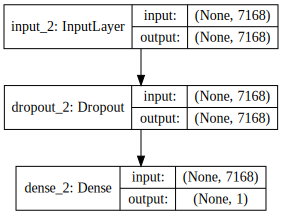

In [14]:
from IPython.display import SVG
#from keras.utils.visualize_util import model_to_dot, plot
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 训练模型

模型构件好了以后，我们就可以进行训练了，这里我们设置验证集大小为 20% ，也就是说训练集是20000张图，验证集是5000张图。

In [15]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 2s - loss: 0.3556 - acc: 0.8958 - val_loss: 0.0236 - val_acc: 0.9930
Epoch 2/8
20000/20000 [==============================] - 2s - loss: 0.0543 - acc: 0.9810 - val_loss: 0.0173 - val_acc: 0.9936
Epoch 3/8
20000/20000 [==============================] - 2s - loss: 0.0372 - acc: 0.9877 - val_loss: 0.0150 - val_acc: 0.9944
Epoch 4/8
20000/20000 [==============================] - 3s - loss: 0.0322 - acc: 0.9895 - val_loss: 0.0155 - val_acc: 0.9942
Epoch 5/8
20000/20000 [==============================] - 2s - loss: 0.0293 - acc: 0.9905 - val_loss: 0.0143 - val_acc: 0.9950
Epoch 6/8
20000/20000 [==============================] - 2s - loss: 0.0259 - acc: 0.9918 - val_loss: 0.0106 - val_acc: 0.9960
Epoch 7/8
20000/20000 [==============================] - 3s - loss: 0.0232 - acc: 0.9932 - val_loss: 0.0104 - val_acc: 0.9966
Epoch 8/8
20000/20000 [==============================] - 2s - loss: 0

In [16]:
model.save('model.h5')

我们可以看到，训练的过程很快，十秒以内就能训练完，准确率也很高，在验证集上最高达到了99.6%的准确率，这相当于一千张图只错了4张，可以说比我还厉害。

# 预测测试集

模型训练好以后，我们就可以对测试集进行预测，然后提交到 kaggle 上看看最终成绩了。

预测这里我们用到了一个小技巧，我们将每个预测值限制到了 [0.005, 0.995] 个区间内，这个原因很简单，kaggle 官方的评估标准是 LogLoss，对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大，是 15 和 2 的差别。参考 LogLoss 如何处理无穷大问题，下面的表达式就是二分类问题的 LogLoss 定义。

$$\textrm{LogLoss} = - \frac{1}{n} \sum{i=1}^n \left[ yi \log(\hat{y}i) + (1 - yi) \log(1 - \hat{y}_i)\right]$$

In [17]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

11904/12500 [===========================>..] - ETA: 0s

In [18]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


## 提升方式

* y_pred = y_pred.clip(min=0.005, max=0.995) 注意这个小技巧，来处理比赛评分的问题
* 采用更新的更多的网络加进来，提取特征向量，进行测试。
* 对模型进行进一步微调，对选择的卷积网络只提取前面的卷积层部分。对最后的层进行修改来让网络更加专注的应用于猫狗的分类。可以关注keras的文章，[面向小数据集构建图像分类模型](http://keras-cn.readthedocs.io/en/latest/blog/image_classification_using_very_little_data/)
* 为了尽量利用我们有限的训练数据，我们将通过一系列随机变换堆数据进行提升，这样我们的模型将看不到任何两张完全相同的图片，这有利于我们抑制过拟合，使得模型的泛化能力更好。在Keras中，这个步骤可以通过keras.preprocessing.image.ImageGenerator来实现。
